In [ ]:
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE13nnn/GSE13159/matrix/GSE13159_series_matrix.txt.gz

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
# import GEOparse
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Model tesets
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


# FAILED ATTEMPT WITH SOFT FILE

In [ ]:
#gse = GEOparse.get_GEO("GSE13159", destdir=".")
#This one to download the database and extract

# gse = GEOparse.get_GEO(filepath="GSE13159_family.soft.gz")
#This one to only extract database

In [ ]:
# # Convert samples into a pandas DataFrame
# samples = []
# for gsm_name, gsm in gse.gsms.items():
#     samples.append(gsm.table)

# # Expression matrix (genes × samples)
# # Use the GPL annotation table to map probes to genes
# expr = gse.pivot_samples('VALUE')
# print(expr.shape)  # e.g., (genes, samples)


In [ ]:
# metadata = []
# for gsm_name, gsm in gse.gsms.items():
#     md = gsm.metadata
#     metadata.append({
#         "sample_id": gsm_name,
#         "title": md["title"][0] if "title" in md else None,
#         "disease": md.get("characteristics_ch1", [""])[0]  # sometimes has disease info
#     })

# meta_df = pd.DataFrame(metadata)
# print(meta_df.head())


# USING TXT SERIES MATRIX

In [ ]:
filename = "GSE13159_series_matrix.txt.gz"

with gzip.open(filename, "rt", errors="ignore") as f:
    for line in f:
        if line.startswith("!Sample"):
            print(line[:200])



In [ ]:
filename = "GSE13159_series_matrix.txt.gz"

expr = pd.read_csv(filename, sep="\t", comment="!", index_col=0)
X = expr.T
print("Expression matrix shape:", X.shape)

sample_ids, labels = [], []
with gzip.open(filename, "rt", errors="ignore") as f:
    for line in f:
        if line.startswith("!Sample_geo_accession"):
            sample_ids = [s.strip('"') for s in line.strip().split("\t")[1:]]
        if line.startswith("!Sample_characteristics_ch1") and "leukemia class" in line:
            raw_labels = line.strip().split("\t")[1:]
            labels = [lbl.split(":")[-1].strip().strip('"') for lbl in raw_labels]

print("Samples in X:", len(X))
print("Samples in labels:", len(labels))

y = pd.DataFrame({"sample_id": sample_ids, "label": labels})

X.to_csv("X.csv")
y.to_csv("y.csv", index=False)

print("✅ Saved X.csv and y.csv")
print("Unique classes:", y['label'].unique())

In [2]:
X = pd.read_csv("X.csv", index_col=0)
y = pd.read_csv("y.csv", index_col=0).squeeze()

In [3]:
print("Features shape:", X.shape)  
print("Labels shape:", y.shape) 
print("Unique labels:", y.unique())


Features shape: (2096, 54675)
Labels shape: (2096,)
Unique labels: ['mature B-ALL with t(8;14)' 'Pro-B-ALL with t(11q23)/MLL'
 'c-ALL/Pre-B-ALL with t(9;22)' 'T-ALL' 'ALL with t(12;21)'
 'ALL with t(1;19)' 'ALL with hyperdiploid karyotype'
 'c-ALL/Pre-B-ALL without t(9;22)' 'AML with t(8;21)' 'AML with t(15;17)'
 'AML with inv(16)/t(16;16)' 'AML with t(11q23)/MLL'
 'AML with normal karyotype + other abnormalities'
 'AML complex aberrant karyotype' 'CLL' 'CML' 'MDS'
 'Non-leukemia and healthy bone marrow']


In [4]:
# Clean label text
y = y.str.replace("leukemia class: ", "", regex=False)
y = y.str.strip()
print(y.value_counts())


label
CLL                                                448
AML with normal karyotype + other abnormalities    351
c-ALL/Pre-B-ALL without t(9;22)                    237
MDS                                                206
T-ALL                                              174
c-ALL/Pre-B-ALL with t(9;22)                       122
CML                                                 76
Non-leukemia and healthy bone marrow                74
Pro-B-ALL with t(11q23)/MLL                         70
ALL with t(12;21)                                   58
AML complex aberrant karyotype                      48
ALL with hyperdiploid karyotype                     40
AML with t(8;21)                                    40
AML with t(11q23)/MLL                               38
AML with t(15;17)                                   37
ALL with t(1;19)                                    36
AML with inv(16)/t(16;16)                           28
mature B-ALL with t(8;14)                           13
Name

In [5]:
def map_label(label: str) -> str:
    label = label.upper() 
    
    if "ALL" in label:
        return "ALL"
    elif "AML" in label:
        return "AML"
    elif "CML" in label:
        return "CML"
    elif "CLL" in label:
        return "CLL"
    elif "MDS" in label:
        return "MDS"
    else:
        return "Healthy"  


In [6]:
y = y.apply(map_label)
print(y.value_counts())


label
ALL        750
AML        542
CLL        448
MDS        206
CML         76
Healthy     74
Name: count, dtype: int64


In [7]:

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(dict(zip(le.classes_, range(len(le.classes_)))))

{'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'Healthy': 4, 'MDS': 5}


In [8]:
print("NaNs ", np.isnan(X.values).sum())
print("Infs ", np.isinf(X.values).sum())
X = X.fillna(0)


NaNs  94320
Infs  0


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled.shape)

(2096, 54675)


In [10]:
selector = SelectKBest(score_func=f_classif, k=10000)
X_reduced = selector.fit_transform(X_scaled, y_encoded)

print("Reduced shape:", X_reduced.shape)


Reduced shape: (2096, 10000)


/run/media/Saksham/Saksham/Code/Projects/Leukemia/Basic_4_types/myenv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [54613 54614 54615 54616 54617 54618 54619 54620 54621 54622 54623 54624
 54639 54640 54641 54645 54646 54647 54648 54649 54650 54651 54652 54653
 54654 54655 54656 54657 54658 54659 54660 54661 54662 54663 54664 54665
 54666 54667 54668 54669 54670 54671 54672 54673 54674] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/run/media/Saksham/Saksham/Code/Projects/Leukemia/Basic_4_types/myenv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_encoded, test_size=0.2, random_state=69, stratify=y_encoded
)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1676, 10000) (1676,) (420, 10000) (420,)


In [12]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_reduced, y_encoded)

print("Before SMOTE:", np.bincount(y_encoded))
print("After SMOTE :", np.bincount(y_res))

# X_train_res, y_train_res = X_train, y_train

Before SMOTE: [750 542 448  76  74 206]
After SMOTE : [750 750 750 750 750 750]


In [13]:
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="liblinear"),
    "Neural Net (MLP)": MLPClassifier(hidden_layer_sizes=(144,72),activation="logistic",solver="adam", max_iter=500)
}

#NOT USING GRADIENT BOOSTING AS IT WAS TAKING TOO MUCH TIME

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_reduced, y_encoded, cv=cv, scoring="accuracy")
    results[name] = (np.mean(scores), np.std(scores))
    print(f"{name:20s}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

Naive Bayes         : 0.908 ± 0.006
Random Forest       : 0.942 ± 0.011
KNN                 : 0.916 ± 0.009
SVM (RBF)           : 0.942 ± 0.009


/run/media/Saksham/Saksham/Code/Projects/Leukemia/Basic_4_types/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/run/media/Saksham/Saksham/Code/Projects/Leukemia/Basic_4_types/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/run/media/Saksham/Saksham/Code/Projects/Leukemia/Basic_4_types/myenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: Fut

Logistic Regression : 0.948 ± 0.011
Neural Net (MLP)    : 0.964 ± 0.015


/tmp/ipykernel_144378/901157336.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="Set2", capsize=0.2)


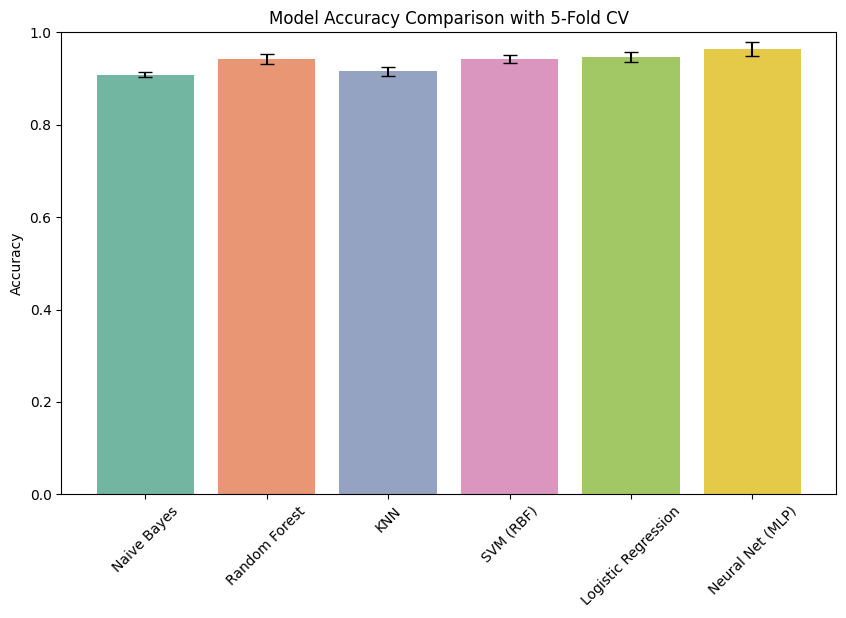

In [16]:
model_names = list(results.keys())
accuracies = [results[name][0] for name in model_names]
stds = [results[name][1] for name in model_names]

plt.figure(figsize=(10,6))
sns.barplot(x=model_names, y=accuracies, palette="Set2", capsize=0.2)
plt.errorbar(x=np.arange(len(model_names)), y=accuracies, yerr=stds, fmt='none', c='black', capsize=5)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison with 5-Fold CV")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()